# Figure 4: Turbine changes to WRF Wind Speeds

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import cmocean.cm as cmo
import xroms
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
from shapely.geometry.polygon import LinearRing
from scipy.stats import geom

from glob import glob
import time
import os
import datetime

In [ ]:
### Load in datasets for baseline and turbine simulations to make a simple difference plot in June 2022

base_ds = xr.open_dataset('baseWRF_202206.nc', chunks={'Time': 1})
turb_ds = xr.open_dataset('turbineWRF_202206.nc', chunks={'Time': 1})

In [18]:
# Get height above surface for centered area within turbine array

ph_grab = base_ds.PH.isel(Time=0, south_north=slice(284,311), west_east=slice(209,228))
phb_grab = base_ds.PHB.isel(Time=0, south_north=slice(284,311), west_east=slice(209,228))

ht_grab = (ph_grab + phb_grab) / 9.8
ht_data = ht_grab.compute()
ht_plot = ht_data.mean(dim=['south_north','west_east'])

(0.0, 15.0)

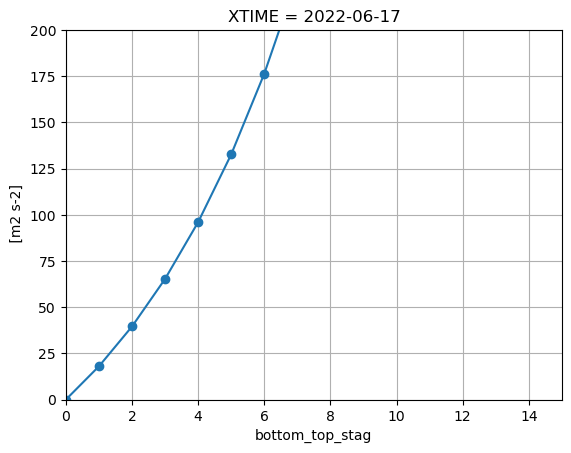

In [22]:
# Simple plot of height at different vertical levels in bottom 200 m of atmosphere

ht_plot.plot.line('-o')
plt.grid()
plt.ylim([0,200])
plt.xlim([0,15])

## Calculate differences

In [ ]:
# Average baseline/turbine velocities to rho points

budel = (base_ds.U.isel(west_east_stag=slice(1,None)).values + base_ds.U.isel(west_east_stag=slice(0,-1)).values) / 2
bvdel = (base_ds.V.isel(south_north_stag=slice(1,None)).values + base_ds.V.isel(south_north_stag=slice(0,-1)).values) / 2

tudel = (turb_ds.U.isel(west_east_stag=slice(1,None)).values + turb_ds.U.isel(west_east_stag=slice(0,-1)).values) / 2
tvdel = (turb_ds.V.isel(south_north_stag=slice(1,None)).values + turb_ds.V.isel(south_north_stag=slice(0,-1)).values) / 2

In [26]:
# Turn baseline rho-centered u and v velocities into xarray data arrays
bdel_uda = xr.DataArray(
    data=budel,
    dims=["Time","bottom_top","south_north","west_east"],
    coords=dict(
        Time=(["Time"], base_ds.Time.values),
        bottom_top=(["bottom_top"], base_ds.bottom_top.values),
        south_north=(["south_north"], base_ds.south_north.values),
        west_east=(["west_east"], base_ds.west_east.values),
        lat=(["south_north","west_east"], base_ds.XLAT.isel(Time=0).values),
        lon=(["south_north","west_east"], base_ds.XLONG.isel(Time=0).values),
    ),
    attrs=dict(
        description="x-wind component",
        units="m s-1",
    ),
)

bdel_vda = xr.DataArray(
    data=bvdel,
    dims=["Time","bottom_top","south_north","west_east"],
    coords=dict(
        Time=(["Time"], base_ds.Time.values),
        bottom_top=(["bottom_top"], base_ds.bottom_top.values),
        south_north=(["south_north"], base_ds.south_north.values),
        west_east=(["west_east"], base_ds.west_east.values),
        lat=(["south_north","west_east"], base_ds.XLAT.isel(Time=0).values),
        lon=(["south_north","west_east"], base_ds.XLONG.isel(Time=0).values),
    ),
    attrs=dict(
        description="y-wind component",
        units="m s-1",
    ),
)

In [27]:
# Turn turbine rho-centered u and v velocities into xarray data arrays
tdel_uda = xr.DataArray(
    data=tudel,
    dims=["Time","bottom_top","south_north","west_east"],
    coords=dict(
        Time=(["Time"], base_ds.Time.values),
        bottom_top=(["bottom_top"], base_ds.bottom_top.values),
        south_north=(["south_north"], base_ds.south_north.values),
        west_east=(["west_east"], base_ds.west_east.values),
        lat=(["south_north","west_east"], base_ds.XLAT.isel(Time=0).values),
        lon=(["south_north","west_east"], base_ds.XLONG.isel(Time=0).values),
    ),
    attrs=dict(
        description="x-wind component",
        units="m s-1",
    ),
)

tdel_vda = xr.DataArray(
    data=tvdel,
    dims=["Time","bottom_top","south_north","west_east"],
    coords=dict(
        Time=(["Time"], base_ds.Time.values),
        bottom_top=(["bottom_top"], base_ds.bottom_top.values),
        south_north=(["south_north"], base_ds.south_north.values),
        west_east=(["west_east"], base_ds.west_east.values),
        lat=(["south_north","west_east"], base_ds.XLAT.isel(Time=0).values),
        lon=(["south_north","west_east"], base_ds.XLONG.isel(Time=0).values),
    ),
    attrs=dict(
        description="y-wind component",
        units="m s-1",
    ),
)

In [28]:
# Calculate speeds of baseline/turbine simulations, compute difference
base_hmap = np.sqrt(bdel_uda**2 + bdel_vda**2)
turb_hmap = np.sqrt(tdel_uda**2 + tdel_vda**2)

diff_hmap = turb_hmap - base_hmap

In [52]:
# grab lon/lat to plot extent of turbine array

lonc0 = ttest.XLONG.isel(Time=0, south_north=210, west_east=285).values
lonc1 = ttest.XLONG.isel(Time=0, south_north=210, west_east=312).values
lonc2 = ttest.XLONG.isel(Time=0, south_north=229, west_east=312).values
lonc3 = ttest.XLONG.isel(Time=0, south_north=229, west_east=285).values

latc0 = ttest.XLAT.isel(Time=0, south_north=210, west_east=285).values
latc1 = ttest.XLAT.isel(Time=0, south_north=210, west_east=312).values
latc2 = ttest.XLAT.isel(Time=0, south_north=229, west_east=312).values
latc3 = ttest.XLAT.isel(Time=0, south_north=229, west_east=285).values

lonring = np.hstack((lonc0, lonc1, lonc2, lonc3))
latring = np.hstack((latc0, latc1, latc2, latc3))

turbine_ring = LinearRing(list(zip(lonring, latring)))

In [ ]:
# Grab turbine array area u and v velocities

bu_grab = base_ds.U.isel(south_north=slice(210,230), west_east_stag=slice(285,313))
bv_grab = base_ds.V.isel(south_north_stag=slice(210,230), west_east=slice(285,313))


tu_grab = turb_ds.U.isel(south_north=slice(210,230), west_east_stag=slice(285,313))
tv_grab = turb_ds.V.isel(south_north_stag=slice(210,230), west_east=slice(285,313))

Text(0.5, 1.0, 'Turbine Influence on Hub-Height Winds')

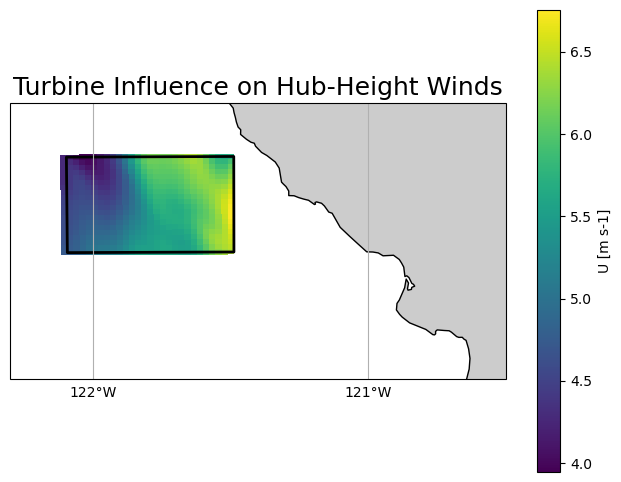

In [57]:
# Example plot of baseline U velocities over turbine array area

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=proj)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = bu_grab.isel(Time=19, bottom_top=0).plot(x='XLONG_U',y='XLAT_U', ax=ax, transform=ccrs.PlateCarree())

ax.add_geometries([turbine_ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-122.3, -120.5, 35, 36], crs=ccrs.PlateCarree())
ax.set_title('Turbine Influence on Hub-Height Winds', fontsize=18)


In [ ]:
# Average horizontal momentum components for baseline and turbine simulations

bu_avg = bu_grab.mean(dim=['south_north','west_east_stag']).compute()
bv_avg = bv_grab.mean(dim=['south_north_stag','west_east']).compute()

tu_avg = tu_grab.mean(dim=['south_north','west_east_stag']).compute()
tv_avg = tv_grab.mean(dim=['south_north_stag','west_east']).compute()

In [62]:
# Calculate average speed for baseline and turbine simulations, then average height of vertical levels
hbavg = np.sqrt(bu_avg**2 + bv_avg**2)
htavg = np.sqrt(tu_avg**2 + tv_avg**2)

ht_aplot = (ht_plot[1::].values + ht_plot[0:-1].values) / 2

## Combined Plot

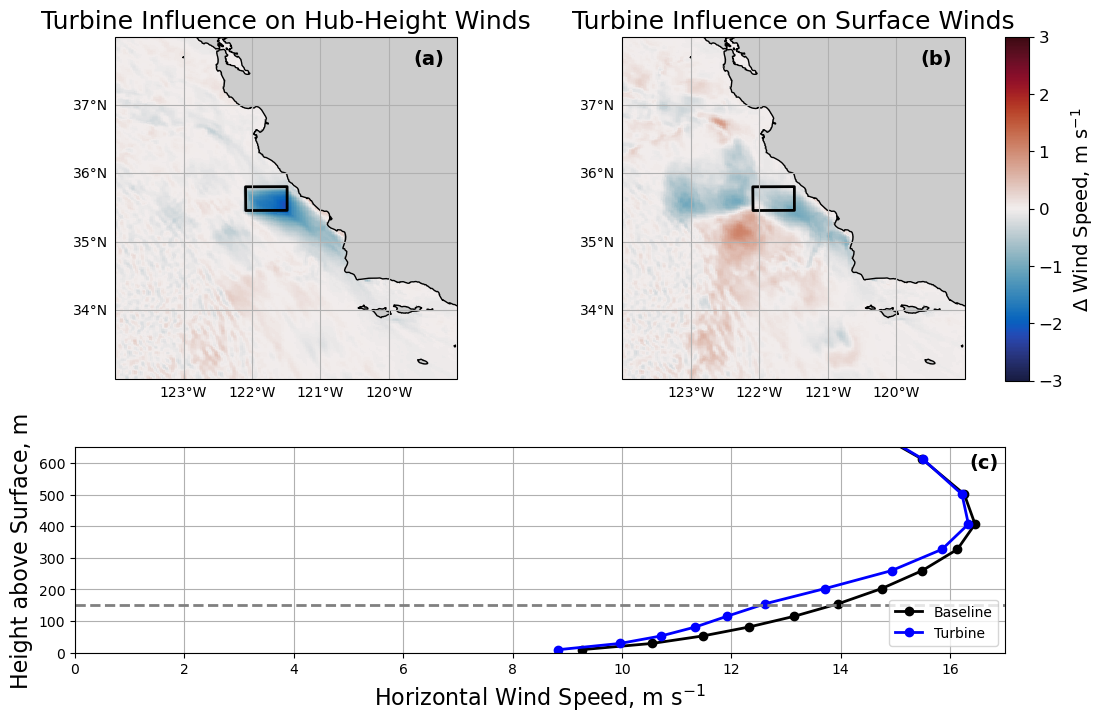

In [81]:
fig = plt.figure(figsize=(12, 8))
proj = ccrs.PlateCarree()

# ax = fig.add_subplot(411)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], wspace=0.2, height_ratios=[1, 0.6], hspace=0.25)

#---------------------------------------------------------------------#
ax = plt.subplot(gs[0, 0], projection=proj)
ax.set_facecolor((0.7, 0.7, 0.7))

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = diff_hmap.mean(dim='Time').isel(bottom_top=5).where(
                                base_ds.LANDMASK.isel(Time=0)==0).plot(
                                x='lon',y='lat', ax=ax, transform=ccrs.PlateCarree(),
                                vmin=-3, vmax=3, cmap=cmo.balance, add_colorbar=False)

ax.add_geometries([turbine_ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-124, -119, 33, 38], crs=ccrs.PlateCarree())
ax.set_title('Turbine Influence on Hub-Height Winds', fontsize=18)
ax.text(-119.65, 37.6, '(a)', fontsize=14, fontweight='demibold')

#---------------------------------------------------------------------#
ax = plt.subplot(gs[0, 1], projection=proj)
ax.set_facecolor((0.7, 0.7, 0.7))

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = diff_hmap.mean(dim='Time').isel(bottom_top=0).where(
                                base_ds.LANDMASK.isel(Time=0)==0).plot(
                                x='lon',y='lat', ax=ax, transform=ccrs.PlateCarree(),
                                vmin=-3, vmax=3, cmap=cmo.balance, add_colorbar=False)

ax.add_geometries([turbine_ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-124, -119, 33, 38], crs=ccrs.PlateCarree())
ax.set_title('Turbine Influence on Surface Winds', fontsize=18)
ax.text(-119.65, 37.6, '(b)', fontsize=14, fontweight='demibold')

#---------------------------------------------------------------------#
# colorbar
cax = fig.add_axes([0.9, 0.45, 0.02, 0.43])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel(r'$\Delta$ Wind Speed, m s$^{-1}$', fontsize=14)
cbar.ax.tick_params(labelsize=12)

#---------------------------------------------------------------------#
ax = plt.subplot(gs[1, :])

ax.plot(hbavg.mean(dim='Time'), ht_aplot, '-o', label='Baseline', color='k', linewidth=2)
ax.plot(htavg.mean(dim='Time'), ht_aplot, '-o', label='Turbine', color='b', linewidth=2)

ax.grid()
ax.set_ylim([0,650])
ax.legend(loc='lower right')
ax.set_xlim([0,17])
ax.set_ylabel('Height above Surface, m', fontsize=16)
ax.set_xlabel('Horizontal Wind Speed, m s$^{-1}$', fontsize=16)
plt.axhline(y=150, color='grey', linestyle='--', linewidth=2)
ax.text(16.35, 585, '(c)', fontsize=14, fontweight='demibold')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

fig.savefig('Figure_2.png', format='png', dpi=300, bbox_inches='tight')